# Data pipeline

## Feature selection

In [1]:
import pandas as pd

numeric_features = ['E_NEds', 'E_Bpag',
                    'NEds', 'NDays', 'NPcreated', 'ns_user', 'ns_wikipedia', 'ns_talk', 'ns_userTalk'
                    ]
df = pd.read_csv('mlops_data.csv')
df = df[df['gender'] != 0]

df = df[numeric_features+['gender']]

print(f'Gender-defined records: {len(df)}')
df.head()

Gender-defined records: 3145


,E_NEds,E_Bpag,NEds,NDays,NPcreated,ns_user,ns_wikipedia,ns_talk,ns_userTalk,gender
0,2,2,543,56,4,91,28,6,76,1
2,0,2,57,2927,0,3,0,1,3,1
3,1,2,104,67,2,20,1,2,2,1
5,3,1,1887,4130,62,7,2,31,10,1
7,3,3,5833,3209,108,161,10,9,184,1


### Removing Outliers: Branch lvl 1 : No Women features

In [2]:
numeric_df = df[numeric_features]

# Calculate the Interquartile Range (IQR) for each numeric feature
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using the IQR method for the subset of columns
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).sum()

# Count outliers for each feature
print("Number of outliers for each feature:")
print(outliers)

# Remove outliers from the dataset
df = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Print the shape of the cleaned dataset
print("Shape of the cleaned dataset after removing outliers:", df.shape)

Number of outliers for each feature:
E_NEds            0
E_Bpag            0
NEds            501
NDays             0
NPcreated       429
ns_user         397
ns_wikipedia    526
ns_talk         461
ns_userTalk     452
dtype: int64
Shape of the cleaned dataset after removing outliers: (2175, 10)


### Normalizing features: Branch lvl 2: BoxCox

In [4]:
# Apply Box-Cox transformation (requires positive values)
from scipy.stats import boxcox
import numpy as np

df[numeric_features] = df[numeric_features].apply(lambda x: np.log(x + 1))
# boxcox_features.head()

df.head()

,E_NEds,E_Bpag,NEds,NDays,NPcreated,ns_user,ns_wikipedia,ns_talk,ns_userTalk,gender
2,0.000000,1.098612,4.060443,7.982075,0.000000,1.386294,0.000000,0.693147,1.386294,1
3,0.693147,1.098612,4.653960,4.219508,1.098612,3.044522,0.693147,1.098612,1.098612,1
13,0.693147,1.386294,4.736198,5.187386,1.386294,3.135494,0.000000,1.098612,1.098612,1
16,0.693147,1.098612,4.969813,7.099202,0.693147,3.091042,0.693147,0.000000,1.791759,1
21,1.098612,0.693147,6.049733,6.864848,1.609438,2.397895,1.791759,1.098612,2.484907,1


## Bootstrap and cross validation splitting

In [5]:
from sklearn.utils import resample
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

print(df.columns)

# Separate features (X) and target variable (y)
X = df.drop('gender', axis=1)  
y = df['gender']

# Apply log transformation to positive-valued features
X_transformed = X[numeric_features].apply(lambda x: np.log(x + 1))

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Split the data into training set for cross-validation and holdout set for assessment
X_train, X_holdout, y_train, y_holdout = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Separate majority and minority classes
X_majority = X_train[y_train == 1]  # Majority class (male)
X_minority = X_train[y_train == 2]  # Minority class (female)

# Bootstrap resample the minority class to balance the dataset
X_minority_resampled = resample(X_minority, n_samples=len(X_majority), replace=True, random_state=42)

# Combine resampled minority class with majority class
X_train_balanced = np.vstack((X_majority, X_minority_resampled))
y_train_balanced = np.concatenate((np.ones(len(X_majority)), np.ones(len(X_minority_resampled)) * 2))

# Shuffle the data to prevent bias
shuffle_indices = np.random.permutation(len(X_train_balanced))
X_train_balanced = X_train_balanced[shuffle_indices]
y_train_balanced = y_train_balanced[shuffle_indices]

# Count the number of males and females in the balanced dataset
num_males = np.sum(y_train_balanced == 1)
num_females = np.sum(y_train_balanced == 2)

# Print the counts
print("Number of Males:", num_males)
print("Number of Females:", num_females)

Index(['E_NEds', 'E_Bpag', 'NEds', 'NDays', 'NPcreated', 'ns_user',
       'ns_wikipedia', 'ns_talk', 'ns_userTalk', 'gender'],
      dtype='object')
Number of Males: 1519
Number of Females: 1519


### Train model and assesment

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# Initialize the logistic regression model with increased max_iter and L2 regularization
logistic_reg_model = LogisticRegression(max_iter=1000, penalty='l2', C=1)  # You can adjust the C parameter for regularization strength

# Perform cross-validation on the training set
cv_scores = cross_val_score(logistic_reg_model, X_train_balanced, y_train_balanced, cv=5, scoring='recall')  # You can choose a different number of folds (e.g., cv=10)

# Fit the model on the entire training set
logistic_reg_model.fit(X_train, y_train)

# Assess the model on the holdout set
holdout_score = logistic_reg_model.score(X_holdout, y_holdout)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Print holdout score
print("Holdout Score:", holdout_score)

Cross-Validation Scores: [0.72368421 0.76973684 0.73355263 0.77557756 0.73026316]
Mean CV Score: 0.7465628799722077
Standard Deviation of CV Scores: 0.02162066172206607
Holdout Score: 0.9126436781609195


### Branch lvl 1: Women features

In [46]:
numeric_features = ['E_NEds', 'E_Bpag',
       'NEds', 'NDays', 'NActDays', 'NPages', 'NPcreated', 'ns_user', 'ns_wikipedia', 'ns_talk', 'ns_userTalk',
       'ns_content']

# Subset the DataFrame to include only numeric features
numeric_df = df[numeric_features]

# Calculate the Interquartile Range (IQR) for each numeric feature
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using the IQR method for the subset of columns
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).sum()

# Count outliers for each feature
print("Number of outliers for each feature:")
print(outliers)

# Remove outliers from the dataset
df = df[~((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Print the shape of the cleaned dataset
print("Shape of the cleaned dataset after removing outliers:", df.shape)

Number of outliers for each feature:
E_NEds            0
E_Bpag            0
NEds            501
NDays             0
NActDays        419
NPages          499
NPcreated       429
ns_user         397
ns_wikipedia    526
ns_talk         461
ns_userTalk     452
ns_content      493
dtype: int64
Shape of the cleaned dataset after removing outliers: (2141, 19)


### Branch lvl 2: Log transformation 

In [47]:
import numpy as np

# Apply log transformation to positive-valued features
df_log = df[numeric_features].apply(lambda x: np.log(x + 1))

### Branch lvl 2: Nothing

In [3]:
df_original = df.copy()

## New cross validation 

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Separate features (X) and target variable (y)
X = df.drop('gender', axis=1)  
y = df['gender']

# Apply log transformation to positive-valued features
X_transformed = X[numeric_features].apply(lambda x: np.log(x + 1))

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Split the data into training set for cross-validation and holdout set for assessment
X_train, X_holdout, y_train, y_holdout = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model with increased max_iter
logistic_reg_model = LogisticRegression(max_iter=1000) 

# Perform cross-validation on the training set
cv_scores = cross_val_score(logistic_reg_model, X_train, y_train, cv=5, scoring='recall')  # You can choose a different number of folds (e.g., cv=10)

# Fit the model on the entire training set
logistic_reg_model.fit(X_train, y_train)

# Assess the model on the holdout set
holdout_score = logistic_reg_model.score(X_holdout, y_holdout)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Print holdout score
print("Holdout Score:", holdout_score)


Cross-Validation Scores: [0.99339934 0.98355263 0.99013158 0.99342105 0.99013158]
Mean CV Score: 0.9901272364078514
Standard Deviation of CV Scores: 0.0035994819953162585
Holdout Score: 0.9149425287356322


## Regularization

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Separate features (X) and target variable (y)
X = df.drop('gender', axis=1)  
y = df['gender']

# Apply log transformation to positive-valued features
X_transformed = X[numeric_features].apply(lambda x: np.log(x + 1))

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Split the data into training set for cross-validation and holdout set for assessment
X_train, X_holdout, y_train, y_holdout = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [20]:
# Initialize the logistic regression model with increased max_iter and L2 regularization
logistic_reg_model = LogisticRegression(max_iter=1000, penalty='l2', C=0.01)  # You can adjust the C parameter for regularization strength

# Perform cross-validation on the training set
cv_scores = cross_val_score(logistic_reg_model, X_train, y_train, cv=5, scoring='recall')  # You can choose a different number of folds (e.g., cv=10)

# Fit the model on the entire training set
logistic_reg_model.fit(X_train, y_train)

# Assess the model on the holdout set
holdout_score = logistic_reg_model.score(X_holdout, y_holdout)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Print holdout score
print("Holdout Score:", holdout_score)

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0
Standard Deviation of CV Scores: 0.0
Holdout Score: 0.9103448275862069


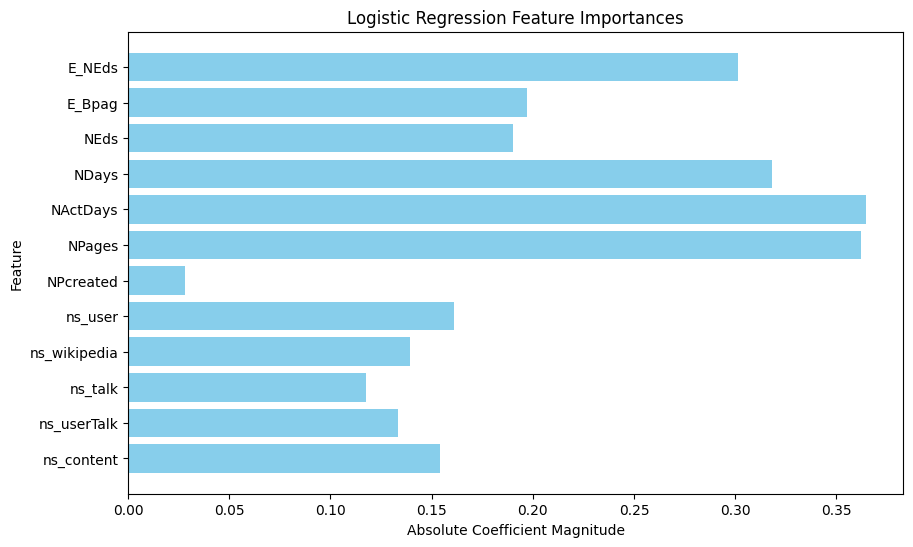

In [49]:
import matplotlib.pyplot as plt

# Get feature importances (coefficients) from the logistic regression model
feature_importances = np.abs(logistic_reg_model.coef_[0])  # Absolute values of coefficients

# Get the names of the features
feature_names = X_transformed.columns  # Use the transformed features instead of the original features

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()




## Logistic Regression women features

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Apply log transformation to positive-valued features
df = df[numeric_features].apply(lambda x: np.log(x + 1))
# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the logistic regression model with increased max_iter
logistic_reg_model = LogisticRegression(max_iter=1000) 

# Perform cross-validation
cv_scores = cross_val_score(logistic_reg_model, X_scaled, y, cv=5, scoring='recall')  # You can choose a different number of folds (e.g., cv=10)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())


Cross-Validation Scores: [0.99734748 0.99734748 0.99734043 0.99734043 1.        ]
Mean CV Score: 0.9978751622552062
Standard Deviation of CV Scores: 0.0010624235566987458


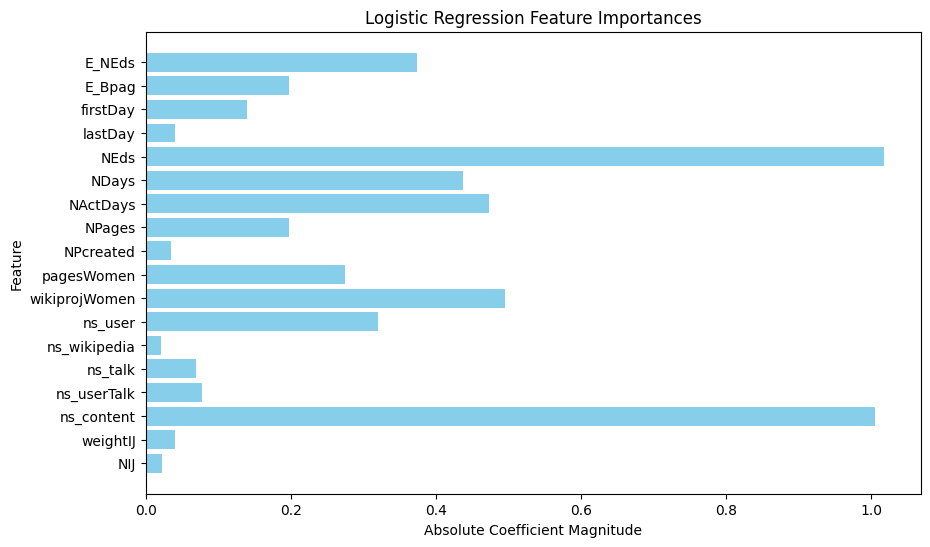

In [5]:
import matplotlib.pyplot as plt

# Fit the logistic regression model
logistic_reg_model.fit(X_scaled, y)

# Get feature importances (coefficients)
feature_importances = np.abs(logistic_reg_model.coef_[0])  # Absolute values of coefficients

# Get the names of the features
feature_names = X.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()



## Gradient Boosting Classifier

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Separate features (X) and target variable (y)
X = df.drop('gender', axis=1)  
y = df['gender']

# Apply log transformation to positive-valued features
X_transformed = X[numeric_features].apply(lambda x: np.log(x + 1))

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Split the data into training set for cross-validation and holdout set for assessment
X_train, X_holdout, y_train, y_holdout = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model with increased max_iter
gb_classifier = GradientBoostingClassifier()

# Perform cross-validation on the training set
cv_scores = cross_val_score(gb_classifier, X_train, y_train, cv=5, scoring='recall')  # You can choose a different number of folds (e.g., cv=10)

# Fit the model on the entire training set
gb_classifier.fit(X_train, y_train)

# Assess the model on the holdout set
holdout_score = gb_classifier.score(X_holdout, y_holdout)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Print holdout score
print("Holdout Score:", holdout_score)


Cross-Validation Scores: [0.97359736 0.96710526 0.97697368 0.99013158 0.98355263]
Mean CV Score: 0.9782721035261421
Standard Deviation of CV Scores: 0.007959504756150832
Holdout Score: 0.8827586206896552


## Random Forest

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Separate features (X) and target variable (y)
X = df.drop('gender', axis=1)  
y = df['gender']

# Apply log transformation to positive-valued features
X_transformed = X[numeric_features].apply(lambda x: np.log(x + 1))

# Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Split the data into training set for cross-validation and holdout set for assessment
X_train, X_holdout, y_train, y_holdout = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model with increased max_iter
rf_classifier = RandomForestClassifier()

# Perform cross-validation on the training set
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='recall')  # You can choose a different number of folds (e.g., cv=10)

# Fit the model on the entire training set
rf_classifier.fit(X_train, y_train)

# Assess the model on the holdout set
holdout_score = rf_classifier.score(X_holdout, y_holdout)

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

# Print holdout score
print("Holdout Score:", holdout_score)


Cross-Validation Scores: [0.98019802 0.97368421 0.99342105 0.98684211 0.97368421]
Mean CV Score: 0.9815659197498696
Standard Deviation of CV Scores: 0.007674583246670287
Holdout Score: 0.8942528735632184
